In [1]:
#Script for cleaning historical weather data from NDBC weather station DB
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import time

import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta

import data_scraper_NDBC as scraper
import plotting_functions


In [2]:
#little function for outputing the number of missing values for each column
def get_nan_count(df):
    missing_values_count = df.isnull().sum()
    print(missing_values_count)


In [3]:
# Quick function for outputing information on a streak of NaN values (e.g. the date range and number of rows over which a sensor was down)

def get_nan_streaks(df_in, column, streak_threshold, verbose=True):
    
    df=df_in.copy(deep=True)
    #df=df.reset_index(drop=True)
    streak=0 
    start_date=0
    end_date=0 
    streak_count=0
    streak_info_matrix=[]
    for i in range(1, len(df)-1):

        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i-1])==False:
            streak+=1
            start_date=df['date'].iloc[i]
        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i-1]) and pd.isna(df[column].iloc[i+1]):
            streak+=1
        if pd.isna(df[column].iloc[i]) and pd.isna(df[column].iloc[i+1])==False:
            streak+=1 
            end_date=df['date'].iloc[i]
            if streak>streak_threshold:
                streak_count+=1
                if verbose==True:
                    print(f'{streak_count-1}: NaN streak in {column} for {streak} rows from {start_date} to {end_date}')
                streak_info_matrix.append([streak_count-1,streak, start_date, end_date])
            streak=0 
            start_date=0
            end_date=0
            
    print(f'SUMMARY: The number of streaks with over {streak_threshold} missing values is {streak_count}')
    return streak_info_matrix




In [4]:
# Funciton to get gaps in data (i.e. dates that were not reported)

def get_data_gaps(df_in, tamedelta_threshold):

    df=df_in.copy(deep=True)

    for i in range(len(df)):
        if df['date'].iloc[i].strftime("%d-%m-%y-%H") not in [df['date'].iloc[i-1].strftime("%d-%m-%y-%H"), (df['date'].iloc[i-1]+timedelta(hours=1)).strftime("%d-%m-%y-%H")]:

            start_date=df['date'].iloc[i-1]
            end_date=df['date'].iloc[i]

            if (end_date-start_date)>tamedelta_threshold:
                print(f'Gap in data from {start_date} to {end_date}')

    

In [5]:
# Funciton to recognize NaN values (most stations report errors/NaN values as "99..")
# Also convert all parameters to floats

def nines_to_nans(df_in, data_columns):

    df=df_in.copy(deep=True)

    for column in data_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

        df[column] = df[column].astype(float)

        #Here we change the value to NaN if it is close to the max value which is likely 99..
        max_value=max(df[column])

        if '99' in str(max_value):
            df[column]=df[column].apply(lambda x: np.NaN if x>max_value-1 else x)
    
    return df

In [6]:
# Function to fill in NaN values with values from the same time but from a different staiton (different df)

def impute_from_different_station(df_in, df_filler, column):
    df=df_in.copy(deep=True)
    dates=[datetime.fromisoformat(date_val).strftime("%d-%m-%y-%H") for date_val in df_filler['date'].values]

    for i in range(len(df)):

        if pd.isna(df[column].iloc[i]):
            fill_date=df['date'].iloc[i]
            fill_date=fill_date.strftime("%d-%m-%y-%H")

            filler_index=0
            
            if fill_date in dates:
                filler_index=dates.index(fill_date)                
                filler_value=df_filler[column].iloc[filler_index]
                df[column].iloc[i]=filler_value
            
    return df



In [7]:
#Query raw data from DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_raw = pd.read_sql_query("SELECT * FROM NDBC_historical_raw_data", conn, index_col=None)


In [8]:
# Convert all parameters to floats. Also this station reports most missing values with "99.." so we replace this with NaN

df_raw["date"] = pd.to_datetime(df_raw["date"])

data_columns=['PRES', 'DEWP', 'WTMP', 'MWD', 'ATMP',  'WDIR','VIS', 'APD', 'DPD', 'WVHT', 'GST', 'WSPD']

df_cleaned=df_raw.copy(deep=True)

df_raw=nines_to_nans(df_raw, data_columns)

df_cleaned=nines_to_nans(df_cleaned, data_columns)

<AxesSubplot:xlabel='date'>

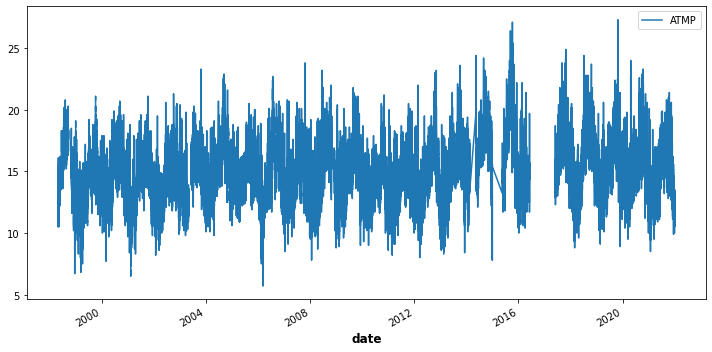

In [35]:
df_raw.plot(x="date", y=['ATMP'],kind="line", figsize=(10, 5))
#plotting_functions.timeseries_plot(df_raw,'date', 'ATMP')

In [10]:
get_nan_count(df_cleaned)

index          0
year           0
month          0
day            0
hour           0
WDIR        2463
WSPD        1969
GST         3078
WVHT      300403
DPD       300407
APD       300399
MWD       375937
PRES        6386
ATMP       53213
WTMP       51780
DEWP      220607
VIS       488253
minute         7
TIDE       18619
date           7
dtype: int64


In [11]:
#Drop columns with too many nans and columns that we dont need
df_cleaned['datetime']=df_cleaned['date']

df_cleaned=df_cleaned.drop(columns=['TIDE', 'VIS', 'DEWP', 'MWD', 'APD', 'DPD','WVHT', 'index', 'year', 'month', 'day', 'hour', 'minute'])
df_cleaned = df_cleaned.dropna(subset=['datetime'])

df_cleaned=df_cleaned.set_index('datetime')


In [12]:
WTMP_streak_info=get_nan_streaks(df_cleaned, 'WTMP', 30)

0: NaN streak in WTMP for 31 rows from 1998-09-25 13:00:00 to 1998-10-27 19:00:00
1: NaN streak in WTMP for 480 rows from 2016-06-23 00:00:00 to 2016-06-26 07:50:00
2: NaN streak in WTMP for 47932 rows from 2016-06-26 08:30:00 to 2017-05-25 17:30:00
SUMMARY: The number of streaks with over 30 missing values is 3


In [13]:
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 30)

0: NaN streak in ATMP for 31 rows from 1998-09-25 13:00:00 to 1998-10-27 19:00:00
1: NaN streak in ATMP for 695 rows from 2003-05-08 15:00:00 to 2003-06-06 13:00:00
2: NaN streak in ATMP for 50808 rows from 2016-06-06 09:10:00 to 2017-05-25 17:30:00
SUMMARY: The number of streaks with over 30 missing values is 3


In [14]:
get_data_gaps(df_cleaned, timedelta(hours=24))

Gap in data from 1998-05-05 23:00:00 to 1998-05-07 00:00:00
Gap in data from 1998-08-29 23:00:00 to 1998-09-19 00:00:00
Gap in data from 1998-09-25 23:00:00 to 1998-10-27 00:00:00
Gap in data from 2008-11-03 22:50:00 to 2008-12-04 17:50:00
Gap in data from 2014-02-17 10:50:00 to 2014-05-14 22:50:00
Gap in data from 2014-12-31 22:50:00 to 2015-05-21 16:30:00
Gap in data from 2017-05-30 05:10:00 to 2017-05-31 07:30:00
Gap in data from 2021-03-09 17:40:00 to 2021-03-15 16:00:00


In [15]:
df_cleaned=df_cleaned[(datetime.fromisoformat('2003-06-06 13:00:00')<df_cleaned['date']) & (df_cleaned['date']<datetime.fromisoformat('2014-02-17 10:50:00'))]

In [16]:
get_nan_count(df_cleaned)

WDIR    545
WSPD     27
GST     173
PRES    117
ATMP     67
WTMP    151
date      0
dtype: int64


In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92634 entries, 2003-06-06 14:00:00 to 2014-02-17 09:50:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    92089 non-null  float64       
 1   WSPD    92607 non-null  float64       
 2   GST     92461 non-null  float64       
 3   PRES    92517 non-null  float64       
 4   ATMP    92567 non-null  float64       
 5   WTMP    92483 non-null  float64       
 6   date    92634 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.7 MB


In [18]:
get_nan_count(df_cleaned)

WDIR    545
WSPD     27
GST     173
PRES    117
ATMP     67
WTMP    151
date      0
dtype: int64


In [19]:
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

0: NaN streak in ATMP for 6 rows from 2003-09-20 05:00:00 to 2003-09-20 10:00:00
SUMMARY: The number of streaks with over 2 missing values is 1


In [20]:
get_data_gaps(df_cleaned, timedelta(hours=24))

Gap in data from 2008-11-03 22:50:00 to 2008-12-04 17:50:00


In [21]:
df_cleaned = df_cleaned.interpolate(method='linear', axis=0).ffill().bfill()

In [22]:
get_nan_count(df_cleaned)

WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64


In [23]:
df_cleaned = df_cleaned.resample("H").mean()

In [24]:
df_cleaned['date']=df_cleaned.index

get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    1179
WSPD    1179
GST     1179
PRES    1179
ATMP    1179
WTMP    1179
date       0
dtype: int64
0: NaN streak in ATMP for 4 rows from 2007-02-17 12:00:00 to 2007-02-17 15:00:00
1: NaN streak in ATMP for 3 rows from 2007-02-19 19:00:00 to 2007-02-19 21:00:00
2: NaN streak in ATMP for 3 rows from 2007-03-05 19:00:00 to 2007-03-05 21:00:00
3: NaN streak in ATMP for 4 rows from 2007-03-20 22:00:00 to 2007-03-21 01:00:00
4: NaN streak in ATMP for 6 rows from 2007-10-10 13:00:00 to 2007-10-10 18:00:00
5: NaN streak in ATMP for 738 rows from 2008-11-03 23:00:00 to 2008-12-04 16:00:00
6: NaN streak in ATMP for 11 rows from 2008-12-07 01:00:00 to 2008-12-07 11:00:00
7: NaN streak in ATMP for 3 rows from 2010-01-04 20:00:00 to 2010-01-04 22:00:00
8: NaN streak in ATMP for 4 rows from 2010-09-07 21:00:00 to 2010-09-08 00:00:00
SUMMARY: The number of streaks with over 2 missing values is 9


In [25]:

#Query raw data from DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_raw_westSB = pd.read_sql_query("SELECT * FROM NDBC_historical_raw_data_St46054", conn, index_col=None)

# Convert all parameters to floats. Also this station reports most missing values with "99.." so we replace this with NaN

data_columns=['PRES', 'DEWP', 'WTMP', 'MWD', 'ATMP',  'WDIR','VIS', 'APD', 'DPD', 'WVHT', 'GST', 'WSPD']

df_cleaned_westSB=df_raw_westSB

df_cleaned_westSB=nines_to_nans(df_cleaned_westSB, data_columns)


df_cleaned_westSB=df_cleaned_westSB.dropna(subset=['date'])
get_nan_count(df_cleaned_westSB)

index          0
year           0
month          0
day            0
hour           0
WDIR       56740
WSPD       13456
GST        20274
WVHT      202427
DPD       202523
APD       202427
MWD       308500
PRES       17599
ATMP      110256
WTMP       80305
DEWP      253578
VIS       376549
minute         0
TIDE       22651
date           0
dtype: int64


In [26]:
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'PRES')
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'ATMP')
df_cleaned=impute_from_different_station(df_cleaned, df_cleaned_westSB, 'WTMP')

C:\Users\dakot\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    1179
WSPD    1179
GST     1179
PRES     185
ATMP     157
WTMP     194
date       0
dtype: int64
0: NaN streak in ATMP for 3 rows from 2008-11-04 10:00:00 to 2008-11-04 12:00:00
1: NaN streak in ATMP for 5 rows from 2008-11-04 21:00:00 to 2008-11-05 01:00:00
2: NaN streak in ATMP for 4 rows from 2008-11-05 03:00:00 to 2008-11-05 06:00:00
3: NaN streak in ATMP for 3 rows from 2008-11-05 12:00:00 to 2008-11-05 14:00:00
4: NaN streak in ATMP for 3 rows from 2008-11-05 16:00:00 to 2008-11-05 18:00:00
5: NaN streak in ATMP for 6 rows from 2008-11-05 23:00:00 to 2008-11-06 04:00:00
6: NaN streak in ATMP for 4 rows from 2008-11-06 06:00:00 to 2008-11-06 09:00:00
7: NaN streak in ATMP for 3 rows from 2010-01-04 20:00:00 to 2010-01-04 22:00:00
SUMMARY: The number of streaks with over 2 missing values is 8


In [28]:
df_cleaned = df_cleaned.interpolate(method='linear', axis=0).ffill().bfill()

In [29]:
get_nan_count(df_cleaned)
get_data_gaps(df_cleaned, timedelta(hours=24))
ATMP_streak_info=get_nan_streaks(df_cleaned, 'ATMP', 2)

WDIR    0
WSPD    0
GST     0
PRES    0
ATMP    0
WTMP    0
date    0
dtype: int64
SUMMARY: The number of streaks with over 2 missing values is 0


<AxesSubplot:xlabel='date'>

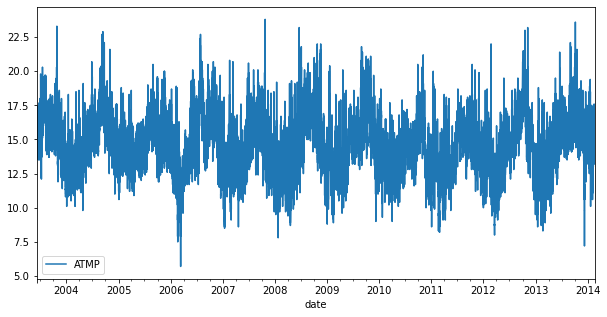

In [30]:
df_cleaned.plot(x="date", y=['ATMP'],kind="line", figsize=(10, 5))

In [31]:
#Save data to local SQLite database
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_cleaned.to_sql(name=f'NDBC_historical_cleaned_data',con=conn,schema='NDBC_model_building_database.db',if_exists='replace') 

In [32]:
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_cleaned_data',)]
